In [26]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, mutual_info_regression

import math
from numpy.linalg import norm

In [27]:
def cup_create_df(path):
    columns = ["id", "a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8", "a9", "output1", "output2"]
    df = pd.read_csv(path, names=columns, delimiter=",", skiprows=7)
    df = df.drop('id', axis=1) #droppiamo id
    return df

cup_tr = cup_create_df('datasets/ML-CUP22-TR.csv')
matrix = cup_tr.to_numpy()
X = matrix[:, :9]
Y = matrix[:, 9:11]

#80% - 20%
X_internal_tr, X_int_test, Y_internal_tr, Y_int_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=72, shuffle=True)
print(type(X_int_test))

<class 'numpy.ndarray'>


In [28]:
#FORMULA MEE 
def MEE(y_true,y_pred,mean=True):
    assert y_pred.shape == y_true.shape, 'x and y must have same shape'
    length = y_pred.shape[0] 
    total = 0
    for i in range(length):
        term_one = abs( y_pred[i][0] - y_true[i][0] )
        term_two = abs( y_pred[i][1] - y_true[i][1] )

        result_in_sqrt = (term_one**2) + (term_two**2)
        result_sqrt = math.sqrt(result_in_sqrt)
        total = total + result_sqrt
    return total/length

In [29]:
custom_mee_scorer = make_scorer(MEE, greater_is_better=False)

pipe = Pipeline([
    ('scaler', None),
    ('knn', KNeighborsRegressor())
                ])

param_grid = {'knn__n_neighbors': [1, 5, 10, 15, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 40],
              'scaler': [StandardScaler(), MinMaxScaler()],
              'knn__weights': ["uniform", "distance"],
              'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
              'knn__p': [2, 3, 4]
              }

knn_gs = GridSearchCV(pipe, param_grid,
                      scoring=custom_mee_scorer,
                      cv=5, n_jobs=-1, 
                      refit=True, 
                      error_score="raise")

knn_gs.fit(X_internal_tr, Y_internal_tr) 
Y_pred = knn_gs.predict(X_internal_tr)

#MIGLIORI PARAMETRI GRID SEARCH
print("Best parameters: ", knn_gs.best_params_)
print("Best MEE score: ", knn_gs.best_score_)
print("Best mean mee score: ", knn_gs.cv_results_['mean_test_score'][0])

Best parameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 20, 'knn__p': 2, 'knn__weights': 'distance', 'scaler': StandardScaler()}
Best MEE score:  -1.4363142173491439
Best mean mee score:  -1.859039951516585


In [30]:
def print_stats_gs(grid_search):
    print('Best setting parameters: ',grid_search.best_params_)
    print('Best score di MEE: ',grid_search.best_score_)
    print('medio valore di MEE su CV: ', grid_search.cv_results_['mean_test_score'][0], 
    '\nStandard Deviation (std) of this setting: ', grid_search.cv_results_['std_test_score'][0])

print_stats_gs(knn_gs)

# mean squared error
mse = mean_squared_error(Y_internal_tr, Y_pred) # Mean Squared Error: 1.561402215791643
print("Mean Squared Error:", mse) 

# mean absolute error
mae = mean_absolute_error(Y_internal_tr, Y_pred) # Mean Absolute Error: 0.843678594956432
print("Mean Absolute Error:", mae)

#R2 SCORE
print("R^2 score:", r2_score(Y_internal_tr ,Y_pred)) #0.9268786046654791

#TEST ERROR
test_error = 1 - mean_squared_error(Y_internal_tr, Y_pred) #-0.561402215791643
print("Test Error:", test_error)

Best setting parameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 20, 'knn__p': 2, 'knn__weights': 'distance', 'scaler': StandardScaler()}
Best score di MEE:  -1.4363142173491439
medio valore di MEE su CV:  -1.859039951516585 
Standard Deviation (std) of this setting:  0.05922642071093625
Mean Squared Error: 0.0
Mean Absolute Error: 0.0
R^2 score: 1.0
Test Error: 1.0


# Plot on TRAINING SET

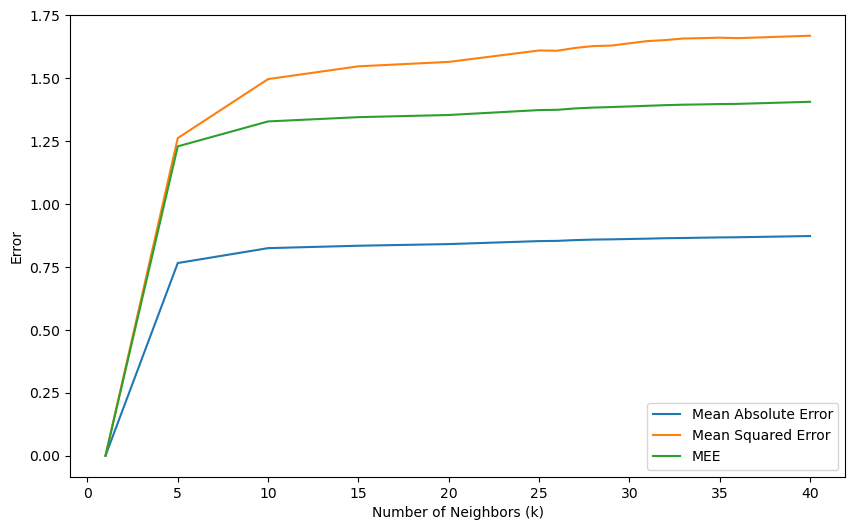

In [31]:
k_values = []
mae_values = []
mse_values = []
mee_values=[]

for k in param_grid['knn__n_neighbors']:
    knn = KNeighborsRegressor(metric="manhattan", n_neighbors=k)
    knn.fit(X_internal_tr, Y_internal_tr)
    Y_pred = knn.predict(X_internal_tr)
    mee = MEE(Y_internal_tr, Y_pred)
    mae = mean_absolute_error(Y_internal_tr, Y_pred)
    mse = mean_squared_error(Y_internal_tr, Y_pred)
    k_values.append(k)
    mee_values.append(mee)
    mae_values.append(mae)
    mse_values.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_values, label='Mean Absolute Error')
plt.plot(k_values, mse_values, label='Mean Squared Error')
plt.plot(k_values, mee_values, label="MEE")
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.legend()
plt.show()

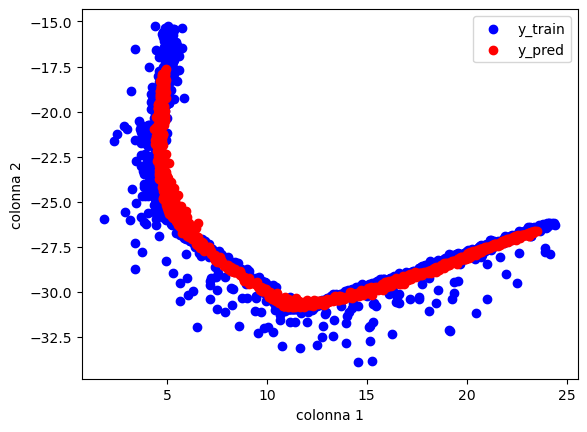

None


In [32]:
def scatter_plot_knn(y_train, y_pred):
    xt_plot = y_train[:, 0]
    yt_plot = y_train[:, 1]

    # Get the x and y values for the y_pred dataset
    xp_plot = y_pred[:, 0]
    yp_plot = y_pred[:, 1]

    # Create the plot
    plt.scatter(xt_plot, yt_plot, color='blue', label='y_train')
    plt.scatter(xp_plot, yp_plot, color='red', label='y_pred')

    # Add labels and a legend
    plt.xlabel('colonna 1') # NB questi valori non rappresentano davvero niente: 
    plt.ylabel('colonna 2') # y_pred e y_train sono composti da due colonne, quindi ho messo una colonna su x e una su y
    plt.legend()            

    # Show the plot
    plt.show()

print(scatter_plot_knn(Y_internal_tr, Y_pred))